<a href="https://colab.research.google.com/github/AJ-Abisola/RNN-Project/blob/Time-series-for-Industrial-Production/RNN_PN_Time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Industrial production time series prediction*

*By AJ ABISOLA*



## Data

*The data is about Industrial Production: Manufacturing: Non-Durable Goods: Ice Cream and Frozen Dessert*

*More Info about this data set: https://fred.stlouisfed.org/series/IPN31152N*

*Frequency:  Monthly*

*The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.*

*NAICS = 31152*

*Source Code: IP.N31152.N*

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019. *italicised text*



In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('IPN31152N.csv',index_col='DATE',parse_dates=True)

In [3]:
df.head()

,IPN31152N
DATE,
1972-01-01,60.1527
1972-02-01,67.2736
1972-03-01,74.4710
1972-04-01,78.3605
1972-05-01,85.0332


In [4]:
df.columns = ['Production']

In [5]:
df.head()

,Production
DATE,
1972-01-01,60.1527
1972-02-01,67.2736
1972-03-01,74.4710
1972-04-01,78.3605
1972-05-01,85.0332


Text(0.5, 1.0, 'Production over time')

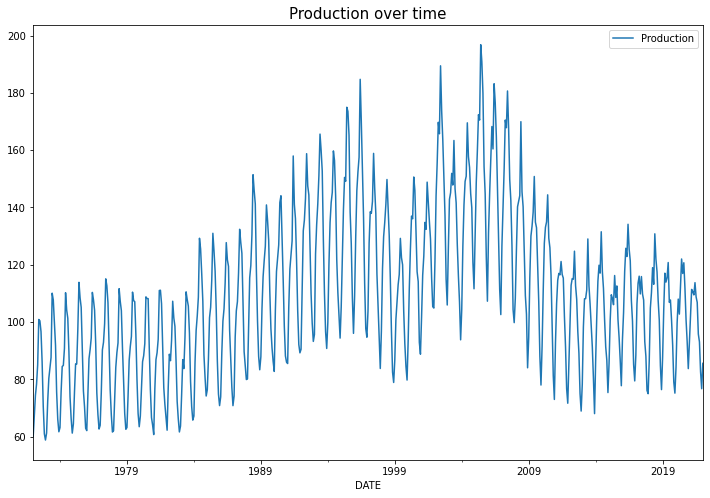

In [6]:
df.plot(figsize=(12,8))
plt.title('Production over time', fontdict={'size':15})

## Train Test Split

In [7]:
len(df)

601

*Splitting the data manually with a test data of 24 months*

In [8]:
test_size = 24
test_ind = len(df)- test_size

In [9]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [10]:
len(test)

24

## Scale Data

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler = MinMaxScaler()

In [13]:
scaler.fit(train)

MinMaxScaler()

In [14]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

*Creating a TimeSeriesGenerator object based off the scaled_train data.*

In [15]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [16]:
length = 18
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [17]:

X,y = generator[0]

In [18]:
#To see the first batch
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00946848 0.06107908 0.11324413 0.1414343  0.18979645 0.30491195
 0.30149681 0.27411766 0.19733775 0.08531415 0.01561386 0.
 0.01773963 0.09849348 0.1558762  0.18355975 0.20875515 0.37144352]
Predict this y: 
 [[0.35419819]]


### Creating the Model



In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [20]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


# *Creating a generator for the scaled test/validation set. *

In [22]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

**TASK: Create an EarlyStopping callback based on val_loss.**

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

**TASK: Fit the model to the generator, let the EarlyStopping dictate the amount of epochs, so feel free to set the parameter high.**

In [25]:
# CODE HERE

In [26]:
# fit model
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
559/559 [==============================] - 6s 7ms/step - loss: 0.0275 - val_loss: 0.0066
Epoch 2/20
559/559 [==============================] - 4s 7ms/step - loss: 0.0118 - val_loss: 0.0034
Epoch 3/20
559/559 [==============================] - 4s 7ms/step - loss: 0.0052 - val_loss: 0.0013
Epoch 4/20
559/559 [==============================] - 4s 7ms/step - loss: 0.0039 - val_loss: 6.7898e-04
Epoch 5/20
559/559 [==============================] - 4s 7ms/step - loss: 0.0035 - val_loss: 0.0014
Epoch 6/20
559/559 [==============================] - 4s 7ms/step - loss: 0.0033 - val_loss: 0.0019


In [27]:
loss = pd.DataFrame(model.history.history)
loss.head()

,loss,val_loss
0,0.027511,0.006615
1,0.011829,0.003386
2,0.005198,0.001252
3,0.003895,0.000679
4,0.003531,0.001373


**TASK: Plot the history of the loss that occured during training.**

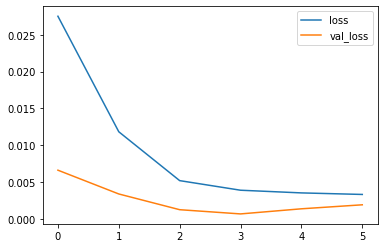

In [28]:

loss.plot()

## Evaluate on Test Data

* Now lets Forecast predictions for the test data range for the last 12 months of the entire dataset.*

In [29]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [30]:
true_predictions = scaler.inverse_transform(test_predictions)

In [31]:
test['Predictions'] = true_predictions

In [32]:
test

,Production,Predictions
DATE,,
2020-02-01,99.7767,98.464403
2020-03-01,108.0301,108.440250
2020-04-01,102.7954,115.380253
2020-05-01,112.5288,120.254420
2020-06-01,122.0301,123.077719
2020-07-01,116.9799,121.784199
2020-08-01,120.7120,116.874579
2020-09-01,111.8634,109.240247
2020-10-01,100.7911,99.825844


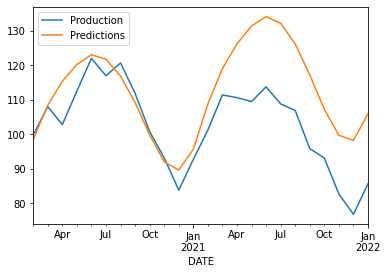

In [33]:
test.plot()

In [45]:
forecast = test.drop('Production', axis =1)

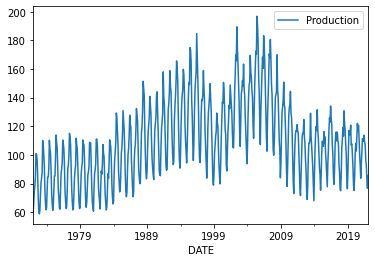

In [36]:
df.plot()

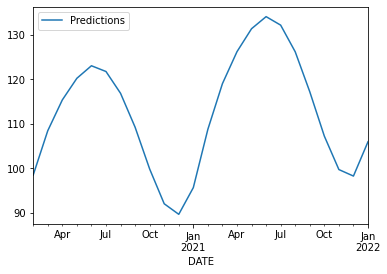

In [46]:
forecast.plot()

<Figure size 1440x1080 with 0 Axes>

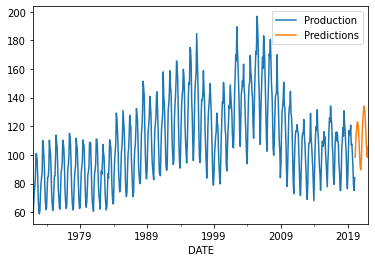

In [47]:
axis= train.plot()
forecast.plot(ax=axis)

In [48]:
from sklearn.metrics import mean_squared_error

In [49]:
np.sqrt(mean_squared_error(test['Production'],test['Predictions']))

13.405584610034197

# *CONCLUSION*

*The time series followed the exact same pattern already established by the data. Considering the type of data, the root mean squared error is minimal.*